In [1]:
import os
from dotenv import find_dotenv, load_dotenv
_ = load_dotenv(find_dotenv())
import json
from utils import json_load, json_dump, mkdir

In [2]:
K = 10
SOURCE_DIR = os.path.join('data', 'deliverables')
exam_dataset_file_path = os.path.join(SOURCE_DIR, 'workflow_result.json')
exam_data = json_load(exam_dataset_file_path)
exam_data[0]

load data from: data/deliverables/workflow_result.json


{'ans': 'B',
 'feedback': '參考資料明確指出「四關穴」由合谷與太衝兩穴組成。',
 'context': '\n\n# 檢索：四關穴 組成穴位\n# 總評：文档多处明确说明“四关穴”由合谷与太冲两对穴位组成，直接回答組成穴位的问题。\n# 結果：\n于明·徐凤所著《针灸大全》“四关者，五脏有六腑，六腑有十二原，十二原出于四关，太冲、合谷是也”。\n- 《针灸大成》中记载: “四关: 四穴，即两合谷、两太冲穴是也。”\n- 四关穴即合谷、太冲，均为原穴，开四关能开通一身气机，调节阴阳升降出入，是临床常用的两个配伍穴。\n\n# 檢索：四關穴 是否包含 合谷 太衝\n# 總評：文中多處明確記載“四關”包含合谷與太衝，可直接回答查詢。\n# 結果：\n“四关者，五脏有六腑，六腑有十二原，十二原出于四关，太冲、合谷是也”。\n- 《针灸大成》中记载: “四关: 四穴，即两合谷、两太冲穴是也。”\n- 四关穴即合谷、太冲，均为原穴，开四关能开通一身气机，调节阴阳升降出入，是临床常用的两个配伍穴。\n\n# 檢索：太衝穴 位置 與合谷 配伍\n# 總評：文件包含合谷與太冲的定位說明及二穴配伍說明，直接回答查詢內容。\n# 結果：\n合谷穴位于手背侧，第１、２掌骨间，在第２掌骨桡侧的中点处。\n- 太冲穴位于足背侧，在第１、２跖骨底结合部前方的凹陷中。\n- 四关穴即合谷、太冲，均为原穴，开四关能开通一身气机，调节阴阳升降出入，是临床常用的两个配伍穴。\n\n合谷穴（LI 4）是手陽明大腸經的原穴，出自《靈樞·本輸》，又名虎口。“合”意即合攏，“谷”是山谷的意思。此穴在第一、二掌骨之間，兩骨相合，形狀如山谷的地方，所以名為合谷。又因位於手拇指虎口兩骨之間，所以又稱為虎口。\n\n-----\n\n',
 'query': '題目: 常見針灸配穴法中,所指的「四關穴」,為下列何穴位之組合?\n選項:\n A: 上星、日月\n B: 合谷、太衝\n C: 內關、外關\n D: 上關、下關\n',
 'reference_answer': 'B'}

In [3]:
exam_data = exam_data[:10]

In [4]:
from llama_index.llms.openai import OpenAI
from llama_index.core.evaluation import FaithfulnessEvaluator
from llama_index.core.evaluation import ContextRelevancyEvaluator
llm = OpenAI(model="gpt-5-mini", temperature=0, is_streaming=False)
faithful = FaithfulnessEvaluator(llm=llm)
context_relevancy = ContextRelevancyEvaluator(llm)

In [5]:
rvs = []
for idx, qset in enumerate(exam_data):
    print(idx, end=', ')
    rv = qset.copy()
    query = qset['query']
    response = f"ans: {qset['ans']}\nfeedback: {qset['feedback']}"
    context = qset['context']
    cr_result = context_relevancy.evaluate(query=query, contexts=[context])
    rv['cr_feedback'] = cr_result.feedback
    rv['cr_score'] = cr_result.score

    ff_result = faithful.evaluate(response=response, contexts=[context])
    rv['ff_feedback'] = ff_result.feedback
    rv['ff_score'] = ff_result.score
    rvs.append(rv)

0, 

/home/poyuan/miniconda3/envs/rag30/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1, 2, 3, 4, 5, 6, 7, 8, 9, 

In [6]:
DEST_DIR = os.path.join('data', 'deliverables')
save_file_path = os.path.join(DEST_DIR, 'workflow_with_proxy.json')
json_dump(save_file_path, rvs)

dump result to: data/deliverables/workflow_with_proxy.json


In [7]:
correct_ff = []
incorrect_ff = []
correct_cr = []
incorrect_cr = []
correct_idx = []
incorrect_idx = []

for idx, data in enumerate(rvs):
    
    ans = data['reference_answer']
    pred = data['ans']
    print(ans, pred)
    if ans == pred:
        correct_idx.append(idx)
        correct_ff.append(data['ff_score'])
        correct_cr.append(data['cr_score'])
    else:
        incorrect_idx.append(idx)
        incorrect_ff.append(data['ff_score'])
        incorrect_cr.append(data['cr_score'])

len(correct_ff), len(incorrect_ff)

B B
A A
A A
D D
B B
C C
C A
B B
A B
C B


(7, 3)

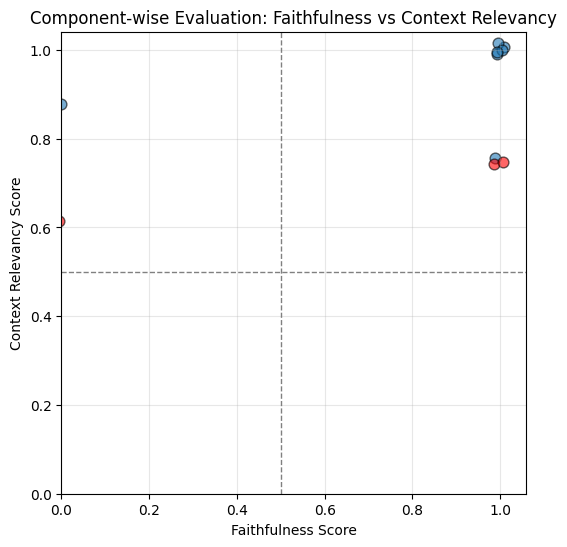

In [8]:
import numpy as np
import matplotlib.pyplot as plt

faithful_score = correct_ff
context_score = correct_cr

# 加上小擾動 (jitter)，避免點完全重疊
jitter_strength = 0.02  # 可以依需求調整
x = faithful_score + np.random.uniform(-jitter_strength, jitter_strength, size=len(faithful_score))
y = context_score + np.random.uniform(-jitter_strength, jitter_strength, size=len(context_score))

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.6, s=60, edgecolor='k')

# 畫 threshold 線 (例如 0.5)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)

plt.xlabel("Faithfulness Score")
plt.ylabel("Context Relevancy Score")
plt.title("Component-wise Evaluation: Faithfulness vs Context Relevancy")
plt.grid(alpha=0.3)


faithful_score = incorrect_ff
context_score = incorrect_cr
# 加上小擾動 (jitter)，避免點完全重疊
jitter_strength = 0.02  # 可以依需求調整
x = faithful_score + np.random.uniform(-jitter_strength, jitter_strength, size=len(faithful_score))
y = context_score + np.random.uniform(-jitter_strength, jitter_strength, size=len(context_score))
plt.scatter(x, y, alpha=0.6, s=60, edgecolor='k', color='r')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()


In [9]:
ffs = []
crs = []
correct = []

for idx, data in enumerate(rvs):
    ans = data['reference_answer']
    pred = data['ans']
    
    if ans == pred:
        correct.append(1)
    else:
        correct.append(0)

    ffs.append(data['ff_score'])
    crs.append(data['cr_score'])

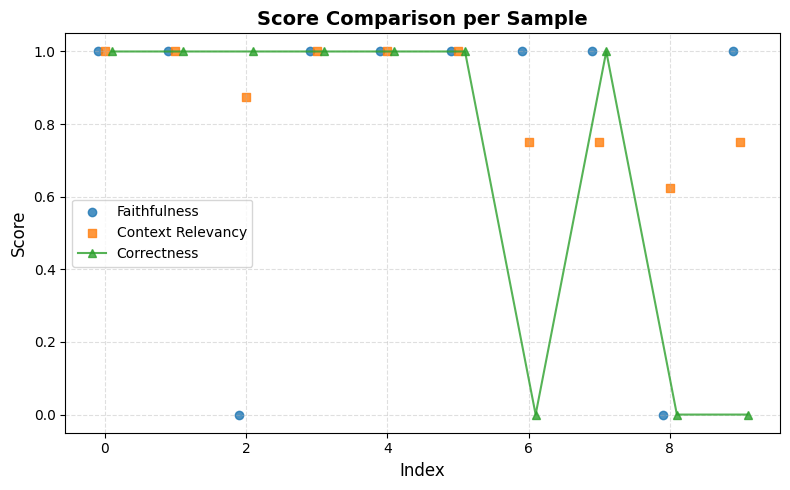

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 假設三個 list
# ffs = [...]
# crs = [...]
# correct = [...]

x = np.arange(len(ffs))
jitter = 0.1  # 微調位置避免重疊

plt.figure(figsize=(8, 5))

plt.scatter(x - jitter, ffs, label='Faithfulness', marker='o', color='#1f77b4', alpha=0.8)
plt.scatter(x, crs, label='Context Relevancy', marker='s', color='#ff7f0e', alpha=0.8)
plt.plot(x + jitter, correct, label='Correctness', marker='^', color='#2ca02c', alpha=0.8)

plt.title("Score Comparison per Sample", fontsize=14, weight='bold')
plt.xlabel("Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
